## Questions:

* Mutual information plots by cell category
* Balanced analysis as a sanity check
* Alluvial plots -- what statistical tests to perform?
* What is probability cell maintains same identity throughout recs?

In [1]:
cd ~/projects/schwarz/decoder

/home/blansdel/projects/schwarz/decoder


In [37]:
import os 
import pandas as pd
import numpy as np
from itertools import combinations, product
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix 
from src.lib import *

sessions = [2, 6, 7, 9]
str_sessions = [str(x) for x in sessions]
events = ['ReSpout_pos', 'ReSpout_neg', \
       'UnSpout_pos', 'UnSpout_neg', 'ReMid_pos', 'ReMid_neg', 'UnMid_pos', \
       'UnMid_neg']
       
fn_in = './data/input/type_info.csv'
df = pd.read_csv(fn_in)
animals = df.Animal.unique()
n_cond = 3
n_animals = len(animals)
conditions = ['Control', 'Idazoxan', 'Clonidine']
cond_map = {'1':'Control',
           '10':'Control',
           '4':'Idazoxan',
           '50':'Clonidine',
           '80':'Idazoxan',
           '83':'Clonidine',
           'F3':'Idazoxan',
           'F4':'Clonidine',
           'M3':'Control'}
df['treatment'] = df.Animal.map(lambda x: cond_map[x])
fn_in = './data/input/explore2.csv'
df_orig = pd.read_csv(fn_in)
df = pd.merge(df, df_orig[['Animal', 'Session', 'CellID', 'MatchID']], on = ['Animal', 'Session', 'CellID'])
df['CellType'] = df['Type'].astype(str)

In [38]:
df

,Animal,Session,CellID,Type,treatment,MatchID,CellType
0,1,2,1,3,Control,1,3
1,1,2,2,3,Control,2,3
2,1,2,3,2,Control,3,2
3,1,2,4,1,Control,4,1
4,1,2,5,2,Control,5,2
...,...,...,...,...,...,...,...
12232,M3,9,455,2,Control,429,2
12233,M3,9,456,4,Control,300,4
12234,M3,9,457,2,Control,400,2
12235,M3,9,458,4,Control,353,4


In [39]:
def mutual_info(x, y, n_cat = 2, labels = None):
    mi = 0
    N = len(x)
    if N == 0: return 0
    assert len(x) == len(y)
    
    if labels is None:
        iterator1 = range(n_cat)
        iterator2 = range(n_cat)
        x = x.astype(int)
        y = y.astype(int)
    else:
        iterator1 = labels 
        iterator2 = labels

    for i in iterator1:
        for j in iterator2:
            pij = sum((x == i) & (y == j))/N
            pi = sum(x == i)/N
            pj = sum(y == j)/N
            if (pij == 0) or (pi == 0) or (pj == 0): continue
            mi += pij*np.log2(pij/pi/pj)
    return mi

### Increases activity as a result of more training

* Find cells that respond *more* strongly at reward spout with *more* training
* Do these cells show the same behavior during retraining?
* Plot correlation matrix of cell response profiles 

cells tracked throughout 4 recordings 114 out of 489
cells tracked throughout 4 recordings 64 out of 286
cells tracked throughout 4 recordings 199 out of 744
cells tracked throughout 4 recordings 100 out of 733
cells tracked throughout 4 recordings 154 out of 402
cells tracked throughout 4 recordings 134 out of 652
cells tracked throughout 4 recordings 83 out of 277
cells tracked throughout 4 recordings 105 out of 423
cells tracked throughout 4 recordings 371 out of 994


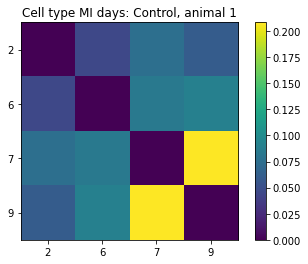

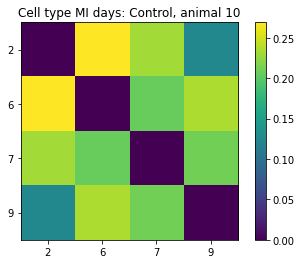

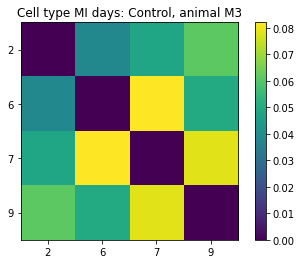

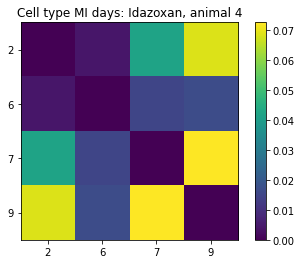

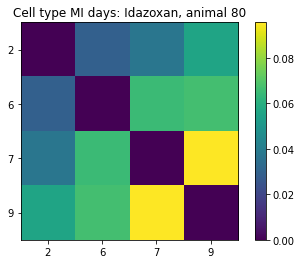

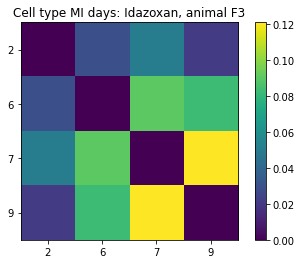

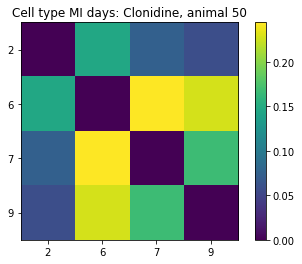

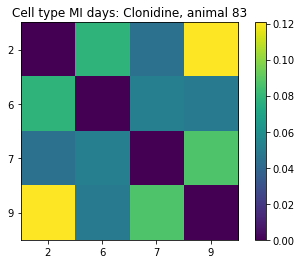

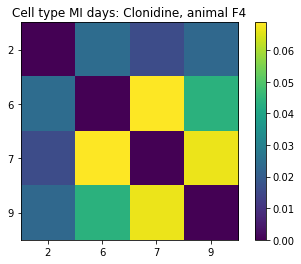

In [40]:
for treatment in conditions:
    animals = df.loc[df.treatment == treatment, "Animal"].unique()
    for animal in animals:
        df_con = df[(df.treatment == treatment) & (df.Animal == animal)]
        cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, treatment)
        cell_fully_tracked = [k for k,v in cell_stats[animal].items() if np.sum(v) == 4]
        print("cells tracked throughout 4 recordings", len(cell_fully_tracked), 'out of', len(cell_stats[animal]))
        celltypes = df_con.CellType.unique()

        mis = np.zeros((4,4))
        for i, s_1 in enumerate(sessions):
            for j, s_2 in enumerate(sessions):
                if s_1 == s_2: continue 
                ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
                ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
                ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
                ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
                ds = pd.merge(ds1, ds2, on = 'MatchID')
                mi = mutual_info(ds[f'CellType_x'], ds[f'CellType_y'], labels = celltypes)
                mis[i,j] = mi
        fig, axes = plt.subplots(1,1)
        plt.imshow(mis)
        plt.title(f'Cell type MI days: {treatment}, animal {animal}')
        plt.colorbar()
        plt.xticks(range(4), labels = sessions)
        plt.yticks(range(4), labels = sessions)

Same thing but with resampling to test significance of these values

cells tracked throughout 4 recordings 114 out of 489
cells tracked throughout 4 recordings 64 out of 286
cells tracked throughout 4 recordings 199 out of 744
cells tracked throughout 4 recordings 100 out of 733
cells tracked throughout 4 recordings 154 out of 402
cells tracked throughout 4 recordings 134 out of 652
cells tracked throughout 4 recordings 83 out of 277
cells tracked throughout 4 recordings 105 out of 423
cells tracked throughout 4 recordings 371 out of 994


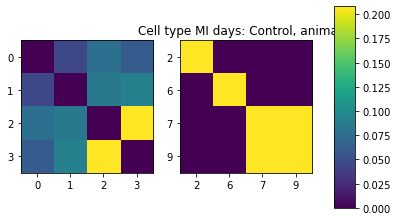

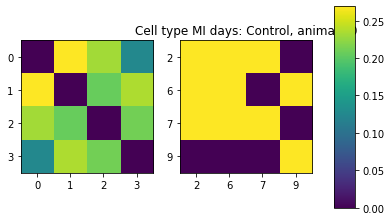

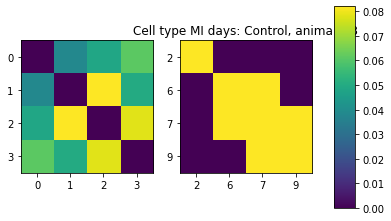

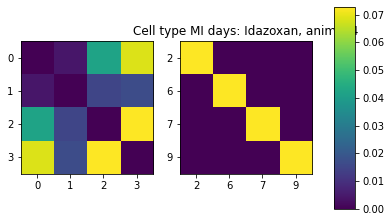

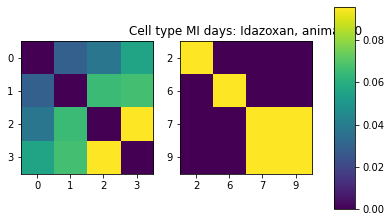

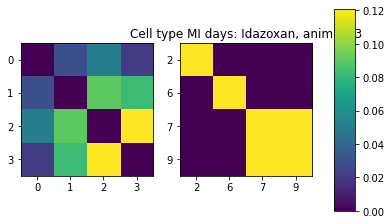

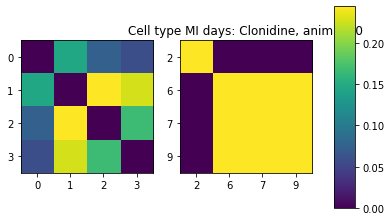

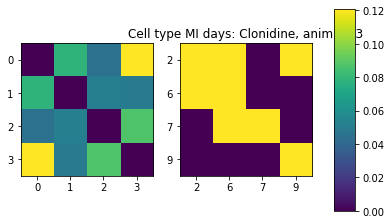

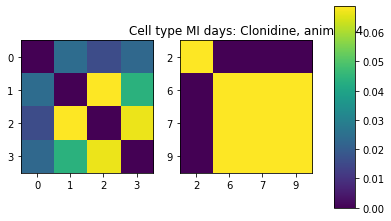

In [41]:
n_reps = 100
alpha = 0.05
mis_all = {}
mis_pvals_all = {}
mis_sig_all = {}
for treatment in conditions:
    mis_all[treatment] = {}
    mis_pvals_all[treatment] = {}
    mis_sig_all[treatment] = {}
    animals = df.loc[df.treatment == treatment, "Animal"].unique()
    for animal in animals:
        df_con = df[(df.treatment == treatment) & (df.Animal == animal)]
        cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, treatment)
        cell_fully_tracked = [k for k,v in cell_stats[animal].items() if np.sum(v) == 4]
        print("cells tracked throughout 4 recordings", len(cell_fully_tracked), 'out of', len(cell_stats[animal]))
        celltypes = df_con.CellType.unique()

        mis = np.zeros((4,4))
        mis_pval = np.zeros((4,4))
        mis_sig = np.zeros((4,4))
        for i, s_1 in enumerate(sessions):
            for j, s_2 in enumerate(sessions):
                if s_1 == s_2: continue 
                ds1 = df_con.loc[df_con.Session == s_1].set_index('MatchID')
                ds1 = ds1[ds1.index.isin(cell_fully_tracked)]
                ds2 = df_con.loc[df_con.Session == s_2].set_index('MatchID')
                ds2 = ds2[ds2.index.isin(cell_fully_tracked)]
                ds = pd.merge(ds1, ds2, on = 'MatchID')
                mi = mutual_info(ds[f'CellType_x'], ds[f'CellType_y'], labels = celltypes)
                #Compute MI null distribution
                null_mis = [mutual_info(ds[f'CellType_x'].values, ds[f'CellType_y'].sample(frac = 1).values, labels = celltypes) for _ in range(n_reps)]
                mis[i,j] = mi
                mis_pval[i,j] = sum(mi < np.array(null_mis))/n_reps

        mis_sig_all[treatment][animal] = mis_pval < alpha
        mis_all[treatment][animal] = mis 
        mis_pvals_all[treatment][animal] = mis_pval

        fig, axes = plt.subplots(1,2)
        im = axes[0].imshow(mis)
        plt.title(f'Cell type MI days: {treatment}, animal {animal}')
        plt.xticks(range(4), labels = sessions)
        plt.yticks(range(4), labels = sessions)
        axes[1].imshow(mis_pval < alpha)
        plt.title(f'Cell type MI days: {treatment}, animal {animal}')
        plt.xticks(range(4), labels = sessions)
        plt.yticks(range(4), labels = sessions)
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        

In [42]:
rows = pd.DataFrame()
for cond in mis_all.keys():
    for animal in mis_all[cond].keys():
        mi = mis_all[cond][animal].flatten()
        mi = mi[mi != 0]
        row = pd.DataFrame({'cond': cond, 'animal': animal, 'mi': mi})
        rows = rows.append(row)

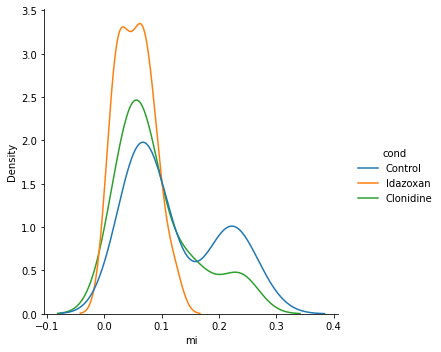

In [43]:
import seaborn as sns 
sns.displot(rows, x = 'mi', hue = 'cond', kind = 'kde')

In [44]:
from scipy.stats import mannwhitneyu
print('Control vs clonidine:', mannwhitneyu(rows.loc[rows['cond'] == 'Control', 'mi'], rows.loc[rows['cond'] == 'Clonidine', 'mi']))
print('Control vs idazoxan:', mannwhitneyu(rows.loc[rows['cond'] == 'Control', 'mi'], rows.loc[rows['cond'] == 'Idazoxan', 'mi']))
print('Idazoxan vs clonidine:', mannwhitneyu(rows.loc[rows['cond'] == 'Idazoxan', 'mi'], rows.loc[rows['cond'] == 'Clonidine', 'mi']))

Control vs clonidine: MannwhitneyuResult(statistic=472.0, pvalue=0.02403739991420169)
Control vs idazoxan: MannwhitneyuResult(statistic=296.0, pvalue=3.764008677375417e-05)
Idazoxan vs clonidine: MannwhitneyuResult(statistic=464.0, pvalue=0.019379025619373536)


In [45]:
threshold = 0.05
from collections import defaultdict
sig_counts = {'Control': defaultdict(int), 'Idazoxan': defaultdict(int), 'Clonidine': defaultdict(int)}
sig_counts_indices = {'Control': defaultdict(int), 'Idazoxan': defaultdict(int), 'Clonidine': defaultdict(int)}
for cond in mis_pvals_all.keys():
    animals = list(mis_pvals_all[cond].keys())
    for animal in animals:
        m = mis_pvals_all[cond][animal]
        indices = zip(*np.where(m <= threshold))
        for idx in indices:
            if idx[0] != idx[1]:
                d1, d2 = min(idx), max(idx)
                days = (sessions[d1], sessions[d2])
                sig_counts[cond][days] += 1
                sig_counts_indices[cond][(d1, d2)] += 1

heatmaps = {}
for cond in mis_pvals_all.keys():
    heatmaps[cond] = np.zeros((4,4))
    for key, val in sig_counts_indices[cond].items():
        heatmaps[cond][key[0], key[1]] = val


Text(0.5, 0.98, 'Proportion of days with significant MI in response')

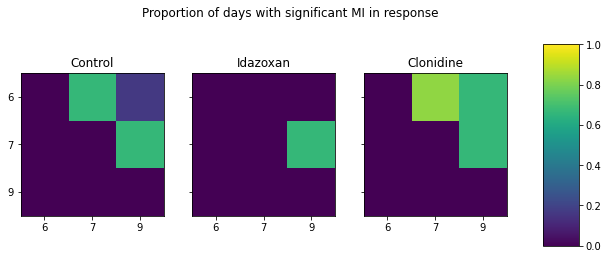

In [47]:
fig, axes = plt.subplots(1,3, figsize = (10,4), sharey = True)
for idx, cond in enumerate(sig_counts_indices.keys()):
    im = axes[idx].imshow(heatmaps[cond][1:,1:]/6, vmin = 0, vmax = 1)
    axes[idx].set_title(cond)        
    axes[idx].set_xticks(range(3))
    axes[idx].set_yticks(range(3))
    axes[idx].set_xticklabels(sessions[1:])
    axes[idx].set_yticklabels(sessions[1:])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle('Proportion of days with significant MI in response')